In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.regression import LinearRegression, GBTRegressor 
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


spark = (
    SparkSession.builder
    .appName("UnemploymentPrediction")
    .config("spark.driver.memory", "4g")
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    .config("spark.ui.port", "4050")
    .getOrCreate()
)

print("Spark Session successfully started.")


25/12/08 00:10:30 WARN SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:490)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
py4j.Gateway.invoke(Gateway.java:238)
py4j.commands.ConstructorCommand.invokeConstructor(ConstructorCommand.java:80)
py4j.commands.Con

Spark Session successfully started.


In [5]:
parquet_path = '../data_bls/integrated_bls_oews_state_year_occ_ecicpi.parquet'

df_spark = spark.read.parquet(parquet_path)

print(f"Total records loaded: {df_spark.count()}")
df_spark.printSchema()
df_spark.show(5, truncate=False)

# keep label the same unless you've renamed it
df_spark = df_spark.withColumn("label", df_spark["State_Unemployment_Rate"].cast("double"))
df_spark = df_spark.drop("State_Unemployment_Rate")


Total records loaded: 312596
root
 |-- Year: long (nullable = true)
 |-- State_FIPS: string (nullable = true)
 |-- Total_Labor_Force: long (nullable = true)
 |-- Total_Employed: long (nullable = true)
 |-- Total_Unemployed: long (nullable = true)
 |-- State_Unemployment_Rate: double (nullable = true)
 |-- OCC_CODE: string (nullable = true)
 |-- OCC_TITLE: string (nullable = true)
 |-- TOT_EMP: double (nullable = true)
 |-- A_MEAN: double (nullable = true)
 |-- A_MEDIAN: double (nullable = true)
 |-- A_PCT10: double (nullable = true)
 |-- A_PCT90: double (nullable = true)
 |-- eci_pct_change: double (nullable = true)
 |-- cpi_inflation_pct: double (nullable = true)
 |-- real_wage_growth: double (nullable = true)



+----+----------+-----------------+--------------+----------------+-----------------------+--------+-----------------------------------+-------+--------+--------+--------+-------+--------------+-----------------+----------------+
|Year|State_FIPS|Total_Labor_Force|Total_Employed|Total_Unemployed|State_Unemployment_Rate|OCC_CODE|OCC_TITLE                          |TOT_EMP|A_MEAN  |A_MEDIAN|A_PCT10 |A_PCT90|eci_pct_change|cpi_inflation_pct|real_wage_growth|
+----+----------+-----------------+--------------+----------------+-----------------------+--------+-----------------------------------+-------+--------+--------+--------+-------+--------------+-----------------+----------------+
|2015|01        |2172619          |2040086       |132533          |6.10014917479779       |11-0000 |Management Occupations             |69100.0|109800.0|95470.0 |52320.0 |NULL   |2.0           |0.4              |1.6             |
|2015|01        |2172619          |2040086       |132533          |6.10014917479

In [6]:
df_spark.printSchema()
df_spark.show(5, truncate=False)
df_spark.columns
[col for col in df_spark.columns if "eci" in col.lower()]
[col for col in df_spark.columns if "cpi" in col.lower()]
[col for col in df_spark.columns if any(k in col.lower() for k in ["wage", "inflation", "real"])]


root
 |-- Year: long (nullable = true)
 |-- State_FIPS: string (nullable = true)
 |-- Total_Labor_Force: long (nullable = true)
 |-- Total_Employed: long (nullable = true)
 |-- Total_Unemployed: long (nullable = true)
 |-- OCC_CODE: string (nullable = true)
 |-- OCC_TITLE: string (nullable = true)
 |-- TOT_EMP: double (nullable = true)
 |-- A_MEAN: double (nullable = true)
 |-- A_MEDIAN: double (nullable = true)
 |-- A_PCT10: double (nullable = true)
 |-- A_PCT90: double (nullable = true)
 |-- eci_pct_change: double (nullable = true)
 |-- cpi_inflation_pct: double (nullable = true)
 |-- real_wage_growth: double (nullable = true)
 |-- label: double (nullable = true)

+----+----------+-----------------+--------------+----------------+--------+-----------------------------------+-------+--------+--------+--------+-------+--------------+-----------------+----------------+----------------+
|Year|State_FIPS|Total_Labor_Force|Total_Employed|Total_Unemployed|OCC_CODE|OCC_TITLE                 

['cpi_inflation_pct', 'real_wage_growth']

In [7]:
#fill na vals with median
cols_to_fill = ["TOT_EMP", "A_MEAN", "A_MEDIAN", "A_PCT10", "A_PCT90", "eci_pct_change", "cpi_inflation_pct", "real_wage_growth",] 

for col in cols_to_fill:
    try:
        median_value = df_spark.approxQuantile(col, [0.5], 0.01)[0]
        df_spark = df_spark.fillna(median_value, subset=[col])
        print(f"Filled missing values in {col} with median: {median_value:.2f}")
    except Exception as e:
        print(f"Error calculating median for {col}: {e}. Skipping or check data quality.")



categorical_cols = ["State_FIPS", "OCC_CODE"]
indexed_cols = [col + "_Index" for col in categorical_cols]
encoded_cols = [col + "_Vec" for col in categorical_cols]


indexers = [
    StringIndexer(inputCol=col, outputCol=col + "_Index", handleInvalid="keep") 
    for col in categorical_cols
]

# OneHotEncoder
encoders = [
    OneHotEncoder(inputCol=col + "_Index", outputCol=col + "_Vec")
    for col in categorical_cols
]

feature_cols = [
    "Year", "Total_Labor_Force", "Total_Employed", "Total_Unemployed",
    "TOT_EMP", "A_MEAN", "A_MEDIAN", "A_PCT10", "A_PCT90", "eci_pct_change", 
    "cpi_inflation_pct", "real_wage_growth",
] + encoded_cols

for col in feature_cols:
    if col not in encoded_cols:
        df_spark = df_spark.withColumn(col, df_spark[col].cast("double"))

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

# split test_trainiing data
train_data, test_data = df_spark.randomSplit([0.8, 0.2], seed=42)
print(f"\nTraining records: {train_data.count()}, Test records: {test_data.count()}")

Filled missing values in TOT_EMP with median: 830.00
Filled missing values in A_MEAN with median: 50420.00
Filled missing values in A_MEDIAN with median: 47600.00
Filled missing values in A_PCT10 with median: 31750.00
Filled missing values in A_PCT90 with median: 71970.00
Filled missing values in eci_pct_change with median: 2.70
Filled missing values in cpi_inflation_pct with median: 2.20
Filled missing values in real_wage_growth with median: 0.40



Training records: 249954, Test records: 62642


In [8]:
gbt = GBTRegressor(
    featuresCol="features", 
    labelCol="label", 
    maxIter=15,         
    maxDepth=5,          
    seed=42
)


pipeline = Pipeline(stages=indexers + encoders + [assembler, gbt])

print("\n--- Starting Model Training (GBT Regressor) ---")
gbt_model = pipeline.fit(train_data) 

print("Model training complete.")

predictions = gbt_model.transform(test_data)
predictions.select("label", "prediction").show(10)


--- Starting Model Training (GBT Regressor) ---


Model training complete.


25/12/08 00:12:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------------+-----------------+
|           label|       prediction|
+----------------+-----------------+
|6.10014917479779|5.560451848249289|
|6.10014917479779|5.560451848249289|
|6.10014917479779|5.560451848249289|
|6.10014917479779|5.560451848249289|
|6.10014917479779|5.560451848249289|
|6.10014917479779|5.560451848249289|
|6.10014917479779|5.560451848249289|
|6.10014917479779|5.560451848249289|
|6.10014917479779|5.560451848249289|
|6.10014917479779|5.560451848249289|
+----------------+-----------------+
only showing top 10 rows



25/12/08 00:12:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [9]:
# evaluate
evaluator_r2 = RegressionEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="r2"
)
evaluator_mae = RegressionEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="mae"
)

#  R-squared
r2 = evaluator_r2.evaluate(predictions)
print(f"\n--- Model Evaluation Results ---")
print(f"R-squared (R2): {r2:.4f}")

# MAE
mae = evaluator_mae.evaluate(predictions)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

if r2 >= 0.85 and mae <= 0.005: 
    print("\n Model meets project targets!")
else:
    print("\n Model still does NOT meet project targets (R2 >= 0.85, MAE <= 0.005).")
    print("Next step: Hyperparameter tuning (CrossValidator) and/or adding ACS PUMS data.")




--- Model Evaluation Results ---
R-squared (R2): 0.9181


Mean Absolute Error (MAE): 0.3884

 Model still does NOT meet project targets (R2 >= 0.85, MAE <= 0.005).
Next step: Hyperparameter tuning (CrossValidator) and/or adding ACS PUMS data.



--- Visualization A: Predicted vs. Actual Values ---


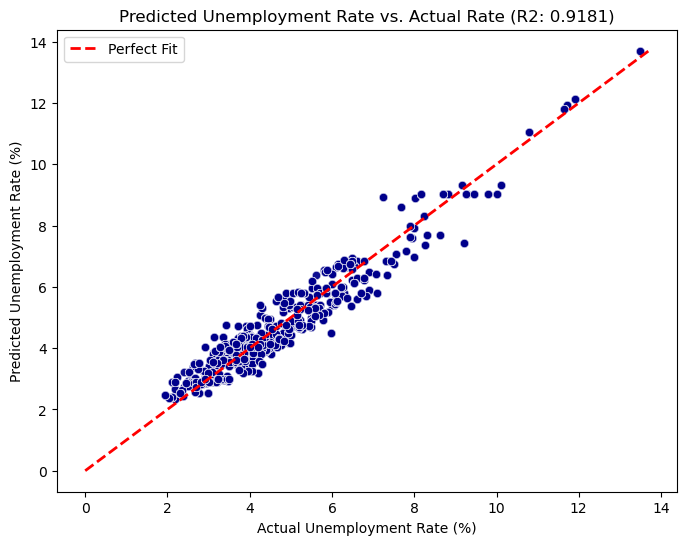


--- Visualization B: Residual Analysis ---


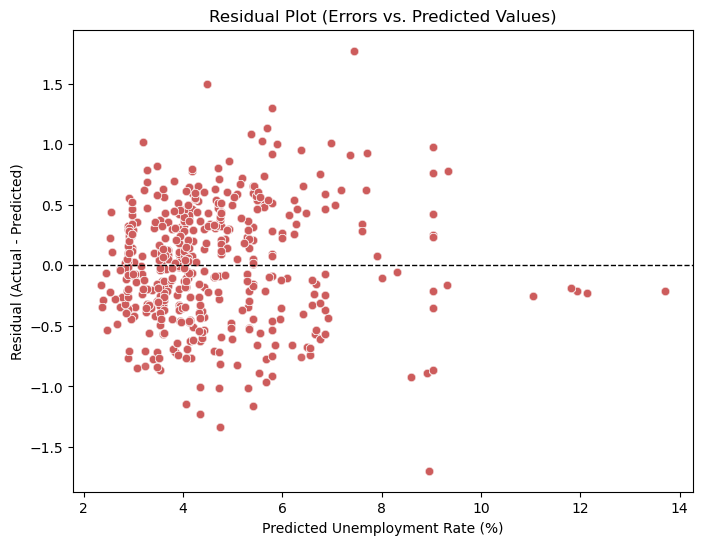

In [10]:

print("\n--- Visualization A: Predicted vs. Actual Values ---")

plot_data_spark = predictions.select("label", "prediction").sample(False, 0.1, seed=42)
plot_data_pd = plot_data_spark.toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='label', 
    y='prediction', 
    data=plot_data_pd, 
    alpha=0.6,
    color='darkblue'
)
max_val = max(plot_data_pd['label'].max(), plot_data_pd['prediction'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Fit')

plt.title(f'Predicted Unemployment Rate vs. Actual Rate (R2: {r2:.4f})')
plt.xlabel('Actual Unemployment Rate (%)')
plt.ylabel('Predicted Unemployment Rate (%)')
plt.legend()
plt.show()

print("\n--- Visualization B: Residual Analysis ---")

predictions_with_residuals = predictions.withColumn(
    "residual", 
    predictions["label"] - predictions["prediction"]
)

residual_plot_data_spark = predictions_with_residuals.select("prediction", "residual").sample(False, 0.1, seed=42)
residual_plot_data_pd = residual_plot_data_spark.toPandas()

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='prediction', 
    y='residual', 
    data=residual_plot_data_pd, 
    alpha=0.6,
    color='indianred'
)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.title('Residual Plot (Errors vs. Predicted Values)')
plt.xlabel('Predicted Unemployment Rate (%)')
plt.ylabel('Residual (Actual - Predicted)')
plt.show()

spark.stop()